# 2.3 Clustering Analysis: Grouping Cities by Profile

**Objective:** Group cities into three categories: "rich," "middle-class," and "poor." I'll use data about their average taxable income, number of taxable households, and median price per square meter to do this. I'll use the **K-Means** algorithm for it.

1.  **Load the Data**: Get the `foyers_fiscaux.csv` and `transactions.npz` files ready.
2.  **Prepare the Data**: Calculate the median price per square meter for each city from the transaction data and then combine it with the fiscal (tax) data. This will give me a single dataset with all the features I need for each city.
3.  **Feature Scaling**: Make sure all the numerical features are on a similar scale so that the clustering algorithm treats them fairly.
4.  **Clustering**: Apply the K-Means algorithm to group the cities into 3 clusters.
5.  **Analyze and Interpret**: Look at the characteristics of each cluster to understand what kind of cities they represent (rich, middle-class, poor).
6.  **Visualize**: Create a plot to show the clusters visually.

In [9]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

## IMPORTANT
Vous devez télécharger le fichier `transactions.npz` [ici](https://www.kaggle.com/datasets/benoitfavier/immobilier-france?select=transactions.npz) et le mettre dans le dossier 2.4

*Github ne nous permet de push des trop gros fichier.*

## 1. Load and Prepare Transaction Data

Loading the `transactions.npz` file and calculating the median price per square meter for each city.

In [10]:
arrays = dict(np.load("transactions.npz"))
data = {k: [s.decode("utf-8") for s in v.tobytes().split(b"\x00")] if v.dtype == np.uint8 else v for k, v in arrays.items()}
transactions = pd.DataFrame.from_dict(data)

# I select only the columns I need
transactions = transactions[['id_ville', 'departement', 'prix', 'surface_habitable']]

# I convert 'prix' and 'surface_habitable' to numbers. If a value can't be converted, it becomes NaN
transactions['prix'] = pd.to_numeric(transactions['prix'], errors='coerce')
transactions['surface_habitable'] = pd.to_numeric(transactions['surface_habitable'], errors='coerce')

# I remove any rows that have missing values for price or surface area
transactions.dropna(subset=['prix', 'surface_habitable'], inplace=True)

# I only keep transactions where the surface habitable is greater than 0 to avoid division by zero
transactions = transactions[transactions['surface_habitable'] > 0]

# I calculate the price per square meter
transactions['prix_m2'] = transactions['prix'] / transactions['surface_habitable']

# To get a more stable result, I remove the extreme outliers (the top 1% and bottom 1% of prices)
lower_bound = transactions['prix_m2'].quantile(0.01)
upper_bound = transactions['prix_m2'].quantile(0.99)
transactions = transactions[transactions['prix_m2'].between(lower_bound, upper_bound)]

# I create a unique ID for each city by combining department and city ID
transactions['departement'] = transactions['departement'].astype(str).str.zfill(2)
transactions['id_ville'] = transactions['id_ville'].astype(str)
transactions['unique_city_id'] = transactions['departement'] + transactions['id_ville']

# I calculate the median price per square meter for each city
median_prices = transactions.groupby('unique_city_id')['prix_m2'].median().reset_index()
median_prices.rename(columns={'prix_m2': 'median_price_per_sqm'}, inplace=True)

print(f"Prepared {len(median_prices)} cities")
median_prices.head()

Prepared 33512 cities


,unique_city_id,median_price_per_sqm
0,011,2023.809524
1,0110,1911.018237
2,01100,994.073661
3,01101,1861.652498
4,01102,1565.011820


## 2. Load and Prepare Fiscal Data

Next, I load the `foyers_fiscaux.csv` file, which contains income and household data for cities.

In [11]:
# I load the fiscal data, making sure the IDs are treated as text
fiscal_df = pd.read_csv("foyers_fiscaux.csv", dtype={'departement': str, 'id_ville': str})

# I create the same unique ID for each city
fiscal_df['departement'] = fiscal_df['departement'].astype(str).str.zfill(2)
fiscal_df['id_ville'] = fiscal_df['id_ville'].astype(str)
fiscal_df['unique_city_id'] = fiscal_df['departement'] + fiscal_df['id_ville']

# I select the columns I need
fiscal_df = fiscal_df[['unique_city_id', 'ville', 'departement', 'revenu_fiscal_moyen', 'n_foyers_fiscaux']]

# I remove any rows with missing financial data
fiscal_df.dropna(subset=['revenu_fiscal_moyen', 'n_foyers_fiscaux'], inplace=True)

print(f"Loaded {len(fiscal_df)} cities")
fiscal_df.head()

Loaded 314721 cities


,unique_city_id,ville,departement,revenu_fiscal_moyen,n_foyers_fiscaux
0,01001,L'Abergement-Clémenciat,01,35291.10,466.0
1,01002,L'Abergement-de-Varey,01,34788.93,143.0
2,01004,Ambérieu-en-Bugey,01,26612.43,9276.0
3,01005,Ambérieux-en-Dombes,01,34712.21,1073.0
4,01006,Ambléon,01,26655.58,78.0


## 3. Merge Datasets

Now I'll combine the two datasets into one, using the `unique_city_id` to match them up. I'll only keep cities that appear in both datasets.

In [12]:
# I merge the two tables on our unique city ID.
# 'inner' merge means I only keep cities that are in both files.
data_df = pd.merge(fiscal_df, median_prices, on='unique_city_id', how='inner')

print(f"Final dataset has {len(data_df)} cities")
data_df.head()

Final dataset has 223804 cities


,unique_city_id,ville,departement,revenu_fiscal_moyen,n_foyers_fiscaux,median_price_per_sqm
0,01100,Cheignieu-la-Balme,01,23858.70,96.0,994.073661
1,01101,Chevillard,01,35936.17,87.0,1861.652498
2,01102,Chevroux,01,31380.80,514.0,1565.011820
3,01103,Chevry,01,60405.86,1083.0,4477.442334
4,01104,Chézery-Forens,01,36809.44,263.0,1665.448343


## 4. Correcting the Clustering with K-Means

**The problem**: Previously, the population size (number of households) biased the results. The algorithm grouped cities based on how big they were, rather than how wealthy they were.

**The fix**: To get an accurate economic profile, we are now clustering based only on:

- Average income.
- Price per square meter.

*The groups now reflect actual economic similarity. We still use the population size for the bubbles in the chart, but only for visualization, so the algorithm isn't "distracted" by it.*

In [17]:
features_for_clustering = ['revenu_fiscal_moyen', 'median_price_per_sqm']
X = data_df[features_for_clustering]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
kmeans.fit(X_scaled)

# I add the cluster number (0, 1, or 2) to my main dataframe
data_df['cluster'] = kmeans.labels_

data_df.head()

,unique_city_id,ville,departement,revenu_fiscal_moyen,n_foyers_fiscaux,median_price_per_sqm,cluster,profile
0,01100,Cheignieu-la-Balme,01,23858.70,96.0,994.073661,0,Poor Cities
1,01101,Chevillard,01,35936.17,87.0,1861.652498,1,Middle-Class Cities
2,01102,Chevroux,01,31380.80,514.0,1565.011820,1,Middle-Class Cities
3,01103,Chevry,01,60405.86,1083.0,4477.442334,2,Rich Cities
4,01104,Chézery-Forens,01,36809.44,263.0,1665.448343,1,Middle-Class Cities


## 5. Analysis and Interpretation

To understand what each cluster means, I look at the average value of each feature for each cluster. This helps me label them as "Poor," "Middle-Class," or "Rich."

In [18]:
# I define the full list of features to analyze, even though clustering was done on a subset
features_to_analyze = ['revenu_fiscal_moyen', 'n_foyers_fiscaux', 'median_price_per_sqm']

cluster_analysis = data_df.groupby('cluster')[features_to_analyze].mean().round(2)
print("Cluster Characteristics (Averages):")
print(cluster_analysis)

# Based on the averages, I can interpret the clusters.
# I sort the clusters by income to give them meaningful names.
sorted_clusters = cluster_analysis.sort_values(by='revenu_fiscal_moyen').index

# I create a mapping from the cluster number to a profile name.
# The cluster with the lowest average income will be 'Poor', the next 'Middle-Class', and the highest 'Rich'.
profile_map = {
    sorted_clusters[0]: 'Poor Cities',
    sorted_clusters[1]: 'Middle-Class Cities',
    sorted_clusters[2]: 'Rich Cities'
}

data_df['profile'] = data_df['cluster'].map(profile_map)

print("\nInterpretation:")
print(f"- {profile_map[sorted_clusters[0]]}: Tend to have lower income and lower real estate prices.")
print(f"- {profile_map[sorted_clusters[1]]}: Represent the average cities.")
print(f"- {profile_map[sorted_clusters[2]]}: Tend to have higher income and higher real estate prices.")

print("\nExamples from each profile:")
print(data_df.groupby('profile')[['ville', 'departement']].first())

Cluster Characteristics (Averages):
         revenu_fiscal_moyen  n_foyers_fiscaux  median_price_per_sqm
cluster                                                             
0                   22158.99            558.57               1133.09
1                   29362.35           1130.89               1804.77
2                   41613.49           3213.08               3146.87

Interpretation:
- Poor Cities: Tend to have lower income and lower real estate prices.
- Middle-Class Cities: Represent the average cities.
- Rich Cities: Tend to have higher income and higher real estate prices.

Examples from each profile:
                                  ville departement
profile                                            
Middle-Class Cities          Chevillard          01
Poor Cities          Cheignieu-la-Balme          01
Rich Cities                      Chevry          01


## 7. Visualization

Finally, I'll create a scatter plot to visualize the clusters. Since it's hard to plot in 3D, I'll make a 2D plot of income vs. price per square meter, using the number of households to determine the size of each point.

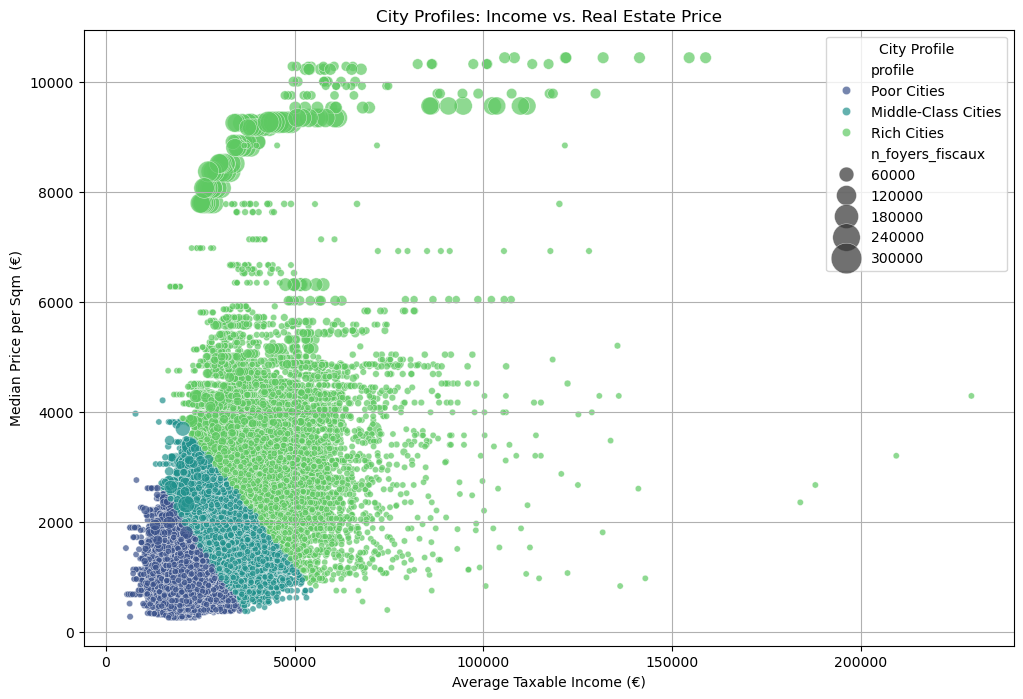

In [19]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=data_df,
    x='revenu_fiscal_moyen',
    y='median_price_per_sqm',
    hue='profile',
    size='n_foyers_fiscaux',
    sizes=(20, 500),
    palette='viridis',
    alpha=0.7
)
plt.title('City Profiles: Income vs. Real Estate Price')
plt.xlabel('Average Taxable Income (€)')
plt.ylabel('Median Price per Sqm (€)')
plt.legend(title='City Profile')
plt.grid(True)
plt.show()